In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from kfda import Kfda
import skfuzzy as fuzz
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("./seeds_dataset.txt", sep='\t', names=["Area", "Perimeter", "Compactedness", "LOK", "WOK", "COA", "HSL", "Lable"])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Area           210 non-null    float64
 1   Perimeter      210 non-null    float64
 2   Compactedness  210 non-null    float64
 3   LOK            210 non-null    float64
 4   WOK            210 non-null    float64
 5   COA            210 non-null    float64
 6   HSL            210 non-null    float64
 7   Lable          210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.2 KB


In [4]:
x = df.drop(["Lable"], axis=1)
y = df["Lable"]

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 77, shuffle = True)
standard = StandardScaler()
x_trs = standard.fit_transform(x_train)
x_tes = standard.transform(x_test) # 防止数据泄露


# PCA + SVM

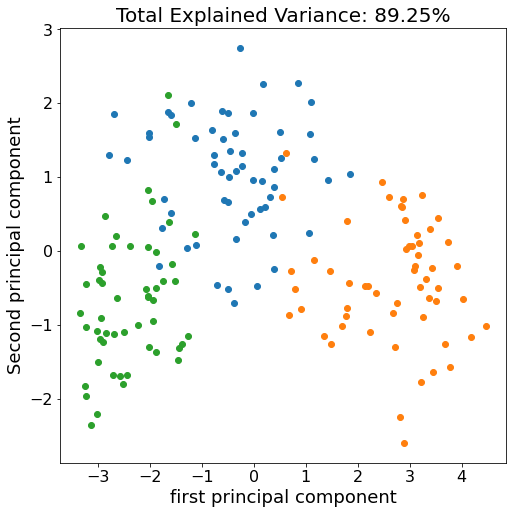

In [32]:
pca = PCA(n_components=2)
x_trp = pca.fit_transform(x_trs)
x_tep = pca.transform(x_tes)
# 如果把总体数据一起做pca，相当于将测试集信息告诉了训练集，会导致之后模型过拟合
# 所以这里只对训练集做pca，用训练集的pca参数transform测试集，图也只显示了训练集的降维情况
# 如果只对数据降维而不做机器学习，可以总体进行降维
tmp=np.c_[x_trp, y_train]
plt.figure(figsize=(8,8))
tmp_1=tmp[tmp[:,2]==1]
tmp_2=tmp[tmp[:,2]==2]
tmp_3=tmp[tmp[:,2]==3]
plt.scatter(tmp_1[:,0], tmp_1[:,1])
plt.scatter(tmp_2[:,0], tmp_2[:,1])
plt.scatter(tmp_3[:,0], tmp_3[:,1])
plt.title(f'Total Explained Variance: {pca.explained_variance_ratio_.sum() * 100:.2f}%', fontsize = 20)
plt.xlabel('first principal component', size=18)
plt.ylabel('Second principal component', size=18)
plt.tick_params('both', labelsize=16)
plt.show()

Text(0, 0.5, 'principal component')

<Figure size 1080x432 with 0 Axes>

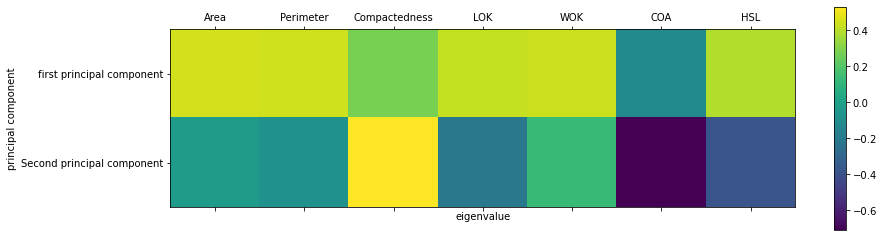

In [37]:
plt.figure(figsize=(15,6))
plt.matshow(pca.components_)
plt.yticks([0,1],["first principal component","Second principal component"])
plt.colorbar()
plt.xticks(range(len(list(x.columns))),x.columns)
plt.xlabel('eigenvalue')
plt.ylabel('principal component')

In [35]:
SVM = SVC()
parameters = {'C': [0.01,0.1,1,5,10,15,20], 'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
SVM_classifier = GridSearchCV(SVM, parameters, scoring='neg_mean_squared_error' ,cv =5, n_jobs=-1) # 网格搜索最佳参数
SVM_classifier.fit(x_trp, y_train)
SVM_classifier.best_params_

{'C': 0.01, 'kernel': 'linear'}

In [36]:
model = SVC(C=0.01, kernel='linear')
model.fit(x_trp , y_train)
accuracy = model.score(x_tep,y_test)
print(f'SVM Classifier Accuracy: {accuracy*100}')

SVM Classifier Accuracy: 92.85714285714286


Text(0, 0.5, 'Second principal component')

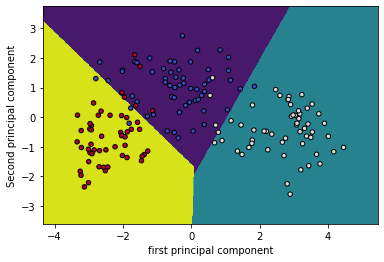

In [44]:
X0, X1 = x_trp[:, 0], x_trp[:, 1]
x0_min, x0_max = X0.min() - 1, X0.max() + 1
x1_min, x1_max = X1.min() - 1, X1.max() + 1
xx, yy = np.meshgrid(np.arange(x0_min, x0_max, 0.02), np.arange(x1_min, x1_max, 0.02))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
plt.xlabel("first principal component")
plt.ylabel("Second principal component")

# KPCA

In [67]:
def data_pro(kl, x_train, x_test, y):
    pca = KernelPCA(n_components=2, kernel=kl)
    x_trp = pca.fit_transform(x_train)
    x_tep = pca.transform(x_test)
    tmp=np.c_[x_trp, y]
    plt.figure(figsize=(8,8))
    tmp_1=tmp[tmp[:,2]==1]
    tmp_2=tmp[tmp[:,2]==2]
    tmp_3=tmp[tmp[:,2]==3]
    plt.scatter(tmp_1[:,0], tmp_1[:,1])
    plt.scatter(tmp_2[:,0], tmp_2[:,1])
    plt.scatter(tmp_3[:,0], tmp_3[:,1])
    # plt.title(f'Total Explained Variance: {lkpca.explained_variance_ratio_.sum() * 100:.2f}%', fontsize = 20)
    plt.xlabel('first principal component', size=18)
    plt.ylabel('Second principal component', size=18)
    plt.tick_params('both', labelsize=16)
    return x_trp, x_tep

In [6]:
def SVM_Select(x_train, y_train):
    SVM = SVC()
    parameters = {'C': [0.01,0.1,1,5,10,15,20], 'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
    SVM_classifier = GridSearchCV(SVM, parameters, scoring='neg_mean_squared_error' ,cv =5, n_jobs=-1) # 网格搜索最佳参数
    SVM_classifier.fit(x_train, y_train)
    return SVM_classifier.best_params_

In [7]:
def SVC_model(x_train, y_train, x_test, y_test):
    best_param = SVM_Select(x_train, y_train)
    model = SVC(C=best_param['C'], kernel=best_param['kernel'])
    model.fit(x_train , y_train)
    accuracy = model.score(x_test,y_test)
    print(f'SVM Classifier Accuracy: {accuracy*100}')
    return model

In [8]:
def plot_SVC(x, y, svcmodel):
    X0, X1 = x[:, 0], x[:, 1]
    x0_min, x0_max = X0.min() - 1, X0.max() + 1
    x1_min, x1_max = X1.min() - 1, X1.max() + 1
    xx, yy = np.meshgrid(np.arange(x0_min, x0_max, 0.02), np.arange(x1_min, x1_max, 0.02))
    Z = svcmodel.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z)
    plt.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    plt.xlabel("first principal component")
    plt.ylabel("Second principal component")


# KPCA:linear + SVM

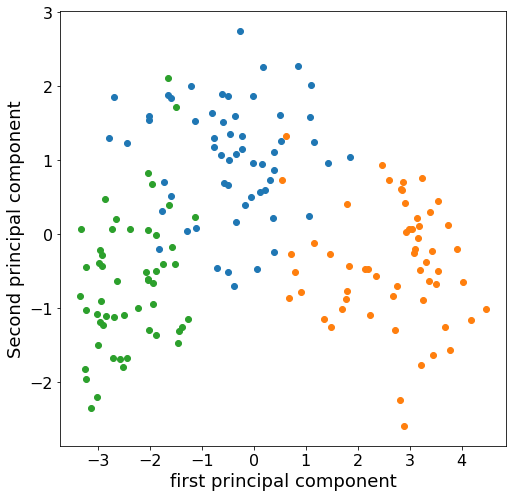

In [100]:
xtrain, xtest = data_pro('linear', x_trs, x_tes, y_train)

SVM Classifier Accuracy: 92.85714285714286


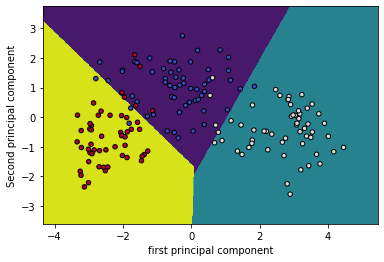

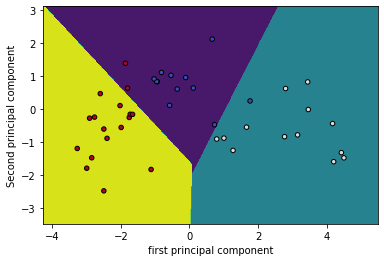

In [103]:
model = SVC_model(xtrain, y_train, xtest, y_test)
plot_SVC(xtrain, y_train, model)
plt.figure()
plot_SVC(xtest, y_test, model)

# KPCA:Poly + SVM

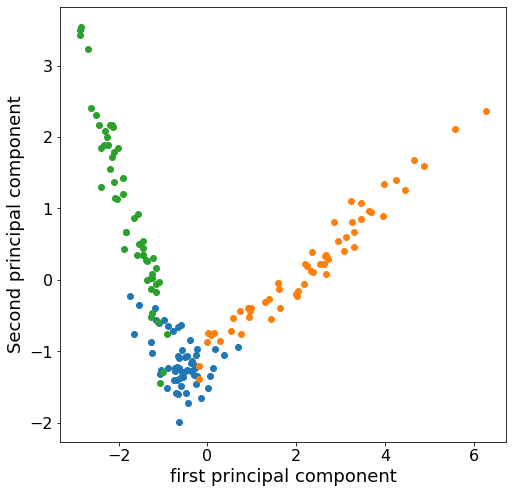

In [104]:
xtrain, xtest = data_pro('poly', x_trs, x_tes, y_train)

SVM Classifier Accuracy: 92.85714285714286


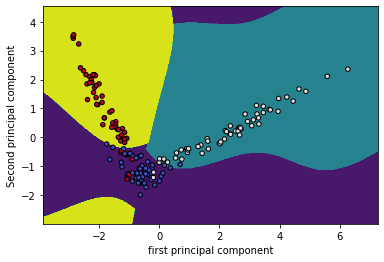

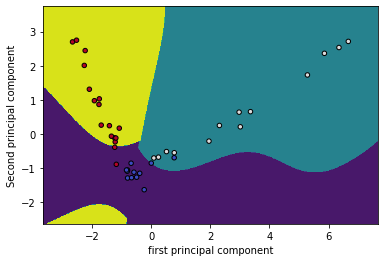

In [105]:
model = SVC_model(xtrain, y_train, xtest, y_test)
plot_SVC(xtrain, y_train, model)
plt.figure()
plot_SVC(xtest, y_test, model)

# KPCA:rbf/Gauss + SVM

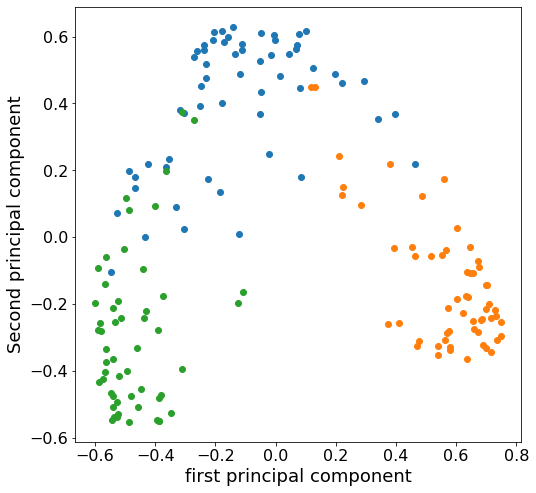

In [107]:
xtrain, xtest = data_pro('rbf', x_trs, x_tes, y_train)

SVM Classifier Accuracy: 92.85714285714286


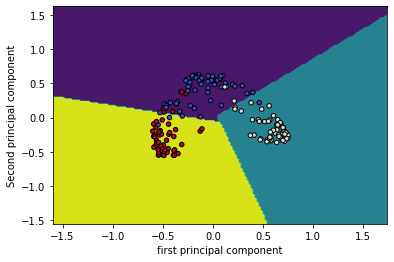

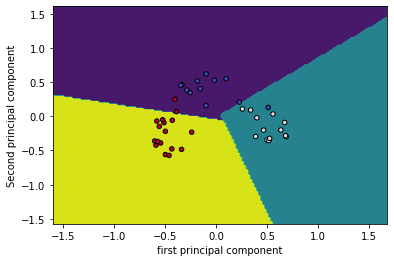

In [108]:
model = SVC_model(xtrain, y_train, xtest, y_test)
plot_SVC(xtrain, y_train, model)
plt.figure()
plot_SVC(xtest, y_test, model)

# lda + SVM

In [84]:
lda = LinearDiscriminantAnalysis(n_components=2)
x_tr_ld = lda.fit_transform(x_trs, y_train)
x_te_ld = lda.transform(x_tes)

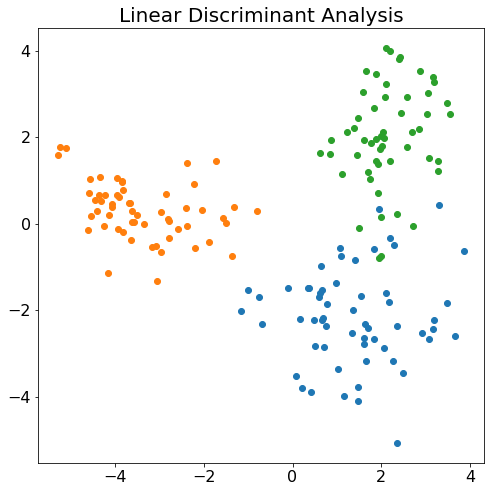

In [87]:
tmp=np.c_[x_tr_ld, y_train]
plt.figure(figsize=(8,8))
tmp_1=tmp[tmp[:,2]==1]
tmp_2=tmp[tmp[:,2]==2]
tmp_3=tmp[tmp[:,2]==3]
plt.scatter(tmp_1[:,0], tmp_1[:,1])
plt.scatter(tmp_2[:,0], tmp_2[:,1])
plt.scatter(tmp_3[:,0], tmp_3[:,1])
plt.title("Linear Discriminant Analysis", fontsize=20)
plt.tick_params('both', labelsize=16)

SVM Classifier Accuracy: 97.61904761904762


Text(0, 0.5, '')

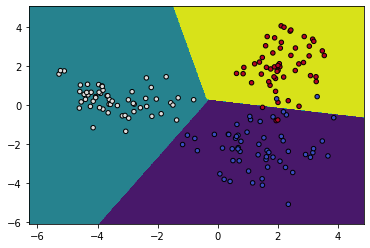

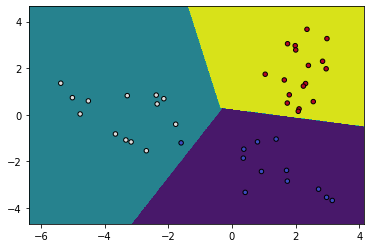

In [110]:
model = SVC_model(x_tr_ld, y_train, x_te_ld, y_test)
plot_SVC(x_tr_ld, y_train, model)
plt.xlabel("")
plt.ylabel("")
plt.figure()
plot_SVC(x_te_ld, y_test, model)
plt.xlabel("")
plt.ylabel("")

# klda+svm

In [10]:
def data_pro_lda(kl, x_train, x_test, y):
    kfda = Kfda(n_components=2, kernel=kl)
    x_trl = kfda.fit_transform(x_train, y)
    x_tel = kfda.transform(x_test)
    tmp=np.c_[x_trl, y]
    plt.figure(figsize=(8,8))
    tmp_1=tmp[tmp[:,2]==1]
    tmp_2=tmp[tmp[:,2]==2]
    tmp_3=tmp[tmp[:,2]==3]
    plt.scatter(tmp_1[:,0], tmp_1[:,1])
    plt.scatter(tmp_2[:,0], tmp_2[:,1])
    plt.scatter(tmp_3[:,0], tmp_3[:,1])
    # plt.title(f'Total Explained Variance: {lkpca.explained_variance_ratio_.sum() * 100:.2f}%', fontsize = 20)
    plt.tick_params('both', labelsize=16)
    return x_trl, x_tel

F:\ProgramData\Anaconda3\envs\dy\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


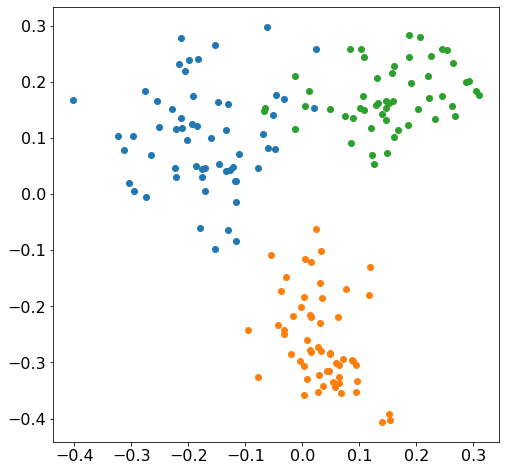

In [130]:
xtrain, xtest = data_pro_lda('linear', x_trs, x_tes, y_train)

SVM Classifier Accuracy: 97.61904761904762


Text(0, 0.5, '')

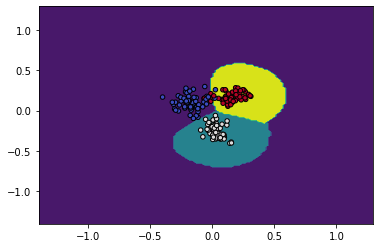

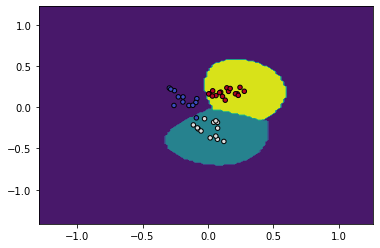

In [131]:
model = SVC_model(xtrain, y_train, xtest, y_test)
plot_SVC(xtrain, y_train, model)
plt.xlabel("")
plt.ylabel("")
plt.figure()
plot_SVC(xtest, y_test, model)
plt.xlabel("")
plt.ylabel("")

F:\ProgramData\Anaconda3\envs\dy\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


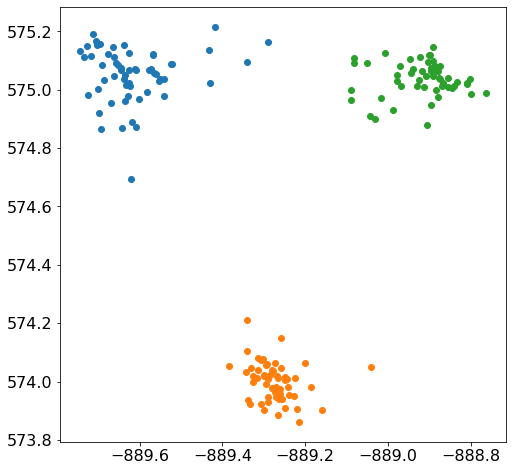

In [13]:
xtrain, xtest = data_pro_lda('poly', x_trs, x_tes, y_train)

SVM Classifier Accuracy: 90.47619047619048


Text(0, 0.5, '')

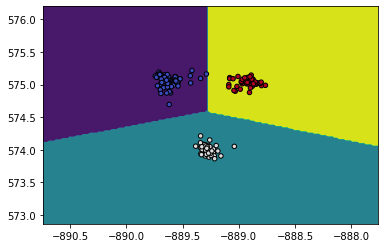

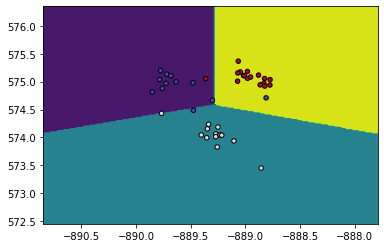

In [25]:
model = SVC_model(xtrain, y_train, xtest, y_test)
plot_SVC(xtrain, y_train, model)
plt.xlabel("")
plt.ylabel("")
plt.figure()
plot_SVC(xtest, y_test, model)
plt.xlabel("")
plt.ylabel("")

F:\ProgramData\Anaconda3\envs\dy\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


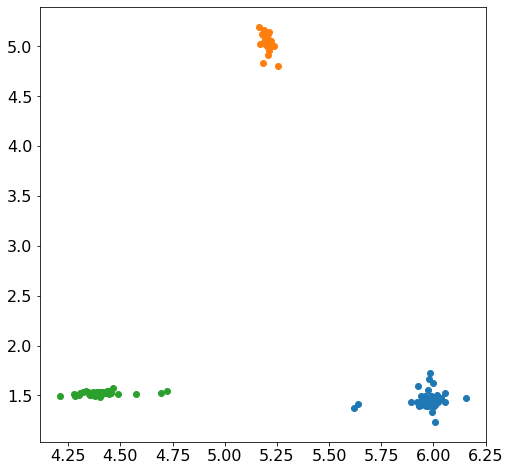

In [26]:
xtrain, xtest = data_pro_lda('rbf', x_trs, x_tes, y_train)

SVM Classifier Accuracy: 95.23809523809523


Text(0, 0.5, '')

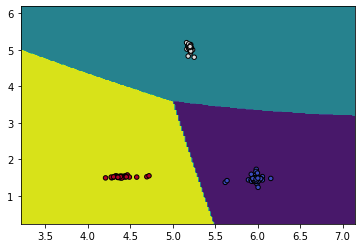

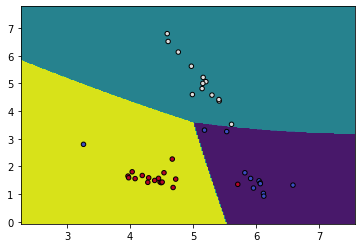

In [27]:
model = SVC_model(xtrain, y_train, xtest, y_test)
plot_SVC(xtrain, y_train, model)
plt.xlabel("")
plt.ylabel("")
plt.figure()
plot_SVC(xtest, y_test, model)
plt.xlabel("")
plt.ylabel("")

# FCM

In [7]:
xs = standard.fit_transform(x)

In [8]:
def datapro4fcm(x, y, pl, kernel):
    if pl == 'PCA':
        if kernel == 'pca':
            pca = PCA(n_components=2)
            xtr = pca.fit_transform(x)
        else:
            kpca = KernelPCA(n_components=2, kernel=kernel)
            xtr = kpca.fit_transform(x)
    else:
        if kernel == 'lda':
            lda = LinearDiscriminantAnalysis(n_components=2)
            xtr = lda.fit_transform(x, y)
        else:
            kfda = Kfda(n_components=2, kernel=kernel)
            xtr = kfda.fit_transform(x, y)
    return xtr

In [9]:
def plotdata(data, y):
    tmp=np.c_[data, y]
    plt.figure(figsize=(8,8))
    tmp_1=tmp[tmp[:,2]==1]
    tmp_2=tmp[tmp[:,2]==2]
    tmp_3=tmp[tmp[:,2]==3]
    plt.scatter(tmp_1[:,0], tmp_1[:,1])
    plt.scatter(tmp_2[:,0], tmp_2[:,1])
    plt.scatter(tmp_3[:,0], tmp_3[:,1])
    # plt.title(f'Total Explained Variance: {pca.explained_variance_ratio_.sum() * 100:.2f}%', fontsize = 20)
    plt.tick_params('both', labelsize=16)
    plt.show()

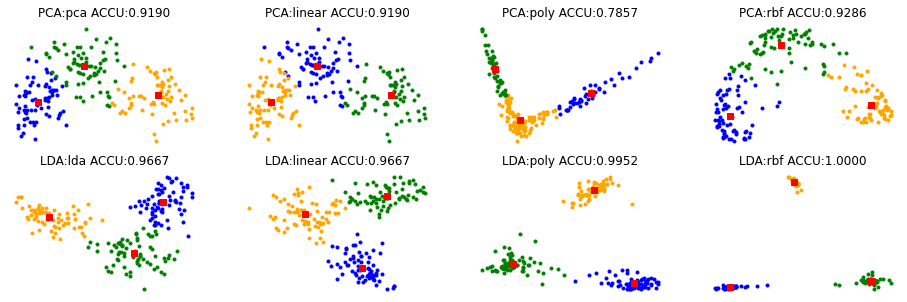

In [31]:
fig, axes = plt.subplots(2, 4, figsize=(16, 5))
axes = axes.reshape(-1)
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']
param = [['PCA', 'LDA'],{'PCA':['pca', 'linear', 'poly', 'rbf'], 'LDA':['lda', 'linear', 'poly', 'rbf']}]
i = 0

for pl in param[0]:
    for kl in param[1][pl]:
        data = datapro4fcm(xs, y, pl, kl)
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, 3, 2, error=0.005, maxiter=1000, init=None)
        # Store fpc values for later
        # Plot assigned clusters, for each data point in training set
        cluster_membership = np.argmax(u, axis=0) + 1
        accuracy = 0.0
        yc = y.copy()
        for j in range(3):
            tmp1 = np.sum(cluster_membership == yc)/yc.shape[0]
            _s = yc.iloc[0]
            _e = yc.iloc[-1]
            yc[yc == _s] = 0
            yc[yc == _e] = _s
            yc[yc == 0] = _e
            tmp2 = np.sum(cluster_membership == yc)/yc.shape[0]
            if (tmp1 > accuracy) or (tmp2 > accuracy):
                accuracy = max(tmp1, tmp2)
            if j != 2:
                yc[yc==1] = 0
                yc[yc==j+2] = 1
                yc[yc==0] = j+2
        for j in range(3):
            axes[i].plot(data[cluster_membership == j+1, 0], data[cluster_membership == j+1, 1], '.', color=colors[j])
            # Mark the center of each fuzzy cluster
        for pt in cntr:
            axes[i].plot(pt[0], pt[1], 'rs')
        axes[i].set_title(f"{pl}:{kl} ACCU:{accuracy:.4f}")
        axes[i].axis('off')
        i = i + 1